In [ ]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

In [ ]:
torch.__version__

'1.13.1+cu116'

In [ ]:
try:
  import pytorch_lightning as pl
except:
  !pip install pytorch_lightning==1.8.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 795.8/795.8 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.4/136.4 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=0250003e7f0ba92b306978cbebf40bc5e582969221341fa09432ecb59d3d2dc0
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire


In [ ]:
!pip install lightning-bolts==0.6.0.post1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.0/330.0 KB 15.6 MB/s eta 0:00:00


# Part 4: VAE with KL divergence

For this part of the lab, you will implement the VAE with the real KL divergence instead of the closed form in part 3. This implementation will be useful when the distributions of P(z|X) and Q(z|X) are not normal distributions. 

Let's start with some preparations same as what we did in part 3. 

## Loading the FashionMNIST Dataset

In [ ]:
%matplotlib inline

import torchvision
import torchvision.transforms as transforms

batch_size = 256
image_dim = 784 #flattened

# dataset construction
transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Lambda(lambda x: x.view(image_dim)) # flatten into vector
    ])

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from itertools import chain

import numpy as np

class Encoder(nn.Module):
    '''
    simple encoder with a single hidden dense layer
    and linear projections to the diag-Gauss parameters
    '''
    ### BEGIN SOLUTION
    def __init__(self, input_dim, hidden_dim, output_dim):
      super(Encoder,self).__init__()
      self.fc1=nn.Linear(input_dim,hidden_dim)
      self.fc2=nn.Linear(hidden_dim,output_dim)
      self.fc3=nn.Linear(hidden_dim,output_dim)
    def forward(self,x):
      x=F.relu(self.fc1(x))
      mean=self.fc2(x)
      log_sigma=self.fc3(x)
      return mean,log_sigma
      
    ### END SOLUTION

class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    ### BEGIN SOLUTION
    def __init__(self,input_dim,hidden_dim,output_dim):
      super(Decoder,self).__init__()
      self.fc4=nn.Linear(input_dim,hidden_dim)
      self.fc5=nn.Linear(hidden_dim,output_dim)
    def forward(self,x):
      x=F.relu(self.fc4(x))
      x=self.fc5(x)
      return torch.sigmoid(x)
    ### END SOLUTION

## FashionMNIST Training

In [ ]:
import matplotlib.gridspec as gridspec    
import os
from torchvision.utils import save_image
import matplotlib.pyplot as plt

#parameters
batch_size = 256
embedding_dim = 2
enc_hidden_units = 512
dec_hidden_units = 512
nEpoch = 15

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_hidden_units, embedding_dim)
dec = Decoder(embedding_dim, dec_hidden_units, image_dim)
optimizer = optim.Adam(chain(enc.parameters(), dec.parameters()), lr=1e-3)

log_scale = nn.Parameter(torch.Tensor([0.0]))

Previously, we assumed that both P and Q follow the Normal distribution and we can use the closed form of KL divergence. Now let's consider the case that P and Q follow other distributions. In such case, we need to code the KL-divergence from its original definition: 

$KL_{div} = \min \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]$

In [ ]:
def kl_divergence(z, mu, std):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------
    # 1. define the first two probabilities (in this case still Normal for both, but can be replaced by any other distributions! Try it.)
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)

    #BEGIN SOLUTION
    # get the probabilities from the equation
    log_qzx = q.log_prob(z)
    log_pz = p.log_prob(z)

    # kl
    kl = (log_qzx - log_pz)
    #END SOLUTION
    # sum over embdding dim
    kl = kl.sum(-1) 
    return kl

In [ ]:
# training loop
for epoch in range(nEpoch):
    losses = []
    trainloader = tqdm(train_loader)

    for i, data in enumerate(trainloader, 0):
        x, _ = data
        optimizer.zero_grad()

        # encode inputs to get the mu and variance parameters
        mu, log_var = enc(x)
        std = torch.exp(log_var / 2)
        # sample z from q
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        # decoded
        x_hat = dec(z)

        # reconstruction loss
        recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum') / x.shape[0] #average over batch size
        
        # kl
        kl = kl_divergence(z, mu, std).sum() / x.shape[0] #average over batch size
        loss = kl + recon_loss

        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)
    
    ## Please display some of the generated images in the submitted Notebook
    # YOUR CODE HERE




 29%|██▉       | 69/235 [00:04<00:11, 13.84it/s, epoch=0, loss=341]


KeyboardInterrupt: ignored

# CIFAR-10 with colorful images - new reconstruction loss

Previously, we just use black-and-white images to train the model, which makes it ok to use binary cross entropy to directly calculate the reconstruction loss. However, what if the images are colorful? i.e. the outputs and inputs are not binary anymore. In this case, we need to turn to the original idea of VAE, and use the gaussian likelihood to describe the reconstruction performance.

In [ ]:
def gaussian_likelihood(x_hat, logscale, x):
    #BEGIN SOLUTION
    scale = torch.exp(logscale)
    mean = x_hat
    dist = torch.distributions.Normal(mean, scale)

    # measure prob of seeing image under p(x|z)
    log_pxz = dist.log_prob(x)
    #END SOLUTION
    return log_pxz.sum(dim=(1,2,3)) 

Now we can define the new VAE model using pytorch_lightning. 

In [ ]:
import pytorch_lightning as pl
from torch import nn
import torch
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)


class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim,
            input_height=input_height,
            first_conv=False,
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def training_step(self, batch, batch_idx):
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded
        x_hat = self.decoder(z) #32 (batch size) *3 *32 *32

        # reconstruction loss - be careful here, we want the gaussian_likelihood being large, so we need to minimize the opposite.
        recon_loss = gaussian_likelihood(x_hat, self.log_scale, x).sum() / x.shape[0]

        # kl
        kl = kl_divergence(z, mu, std).sum() / x.shape[0]

        # loss
        loss = kl - recon_loss

        return loss

Load the CIFAR10 dataset and train the new VAE model.

In [ ]:
from pl_bolts.datamodules import CIFAR10DataModule
cifar_10 = CIFAR10DataModule('.')

In [ ]:
pl.seed_everything(1234)
vae = VAE()
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=60) 
trainer.fit(vae, cifar_10)

INFO:lightning_lite.utilities.seed:Global seed set to 1234
<ipython-input-23-6fc5fdd05658>:17: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
<ipython-input-23-6fc5fdd05658>:18: UnderReviewWarning: The feature resnet18_decoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.decoder = resnet18_decoder(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_ze

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type          | Params
------------------------------------------
0 | encoder | ResNetEncoder | 11.2 M
1 | decoder | ResNetDecoder | 8.6 M 
2 | fc_mu   | Linear        | 131 K 
3 | fc_var  | Linear        | 131 K 
------------------------------------------
20.1 M    Trainable params
0         Non-trainable params
20.1 M    Total params
80.228    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


Now we can visualise some prediction results. Before that, we need to figure out the shape of mu and std. Just to remind that the images in CIFAR10 are with shapes of 3x32x32.

In [ ]:
vae_0 = VAE()
x = torch.rand(1, 3, 32, 32)

print('image shape:', x.shape)

# GET Q(z|x) PARAMETERS
# encode x to get the mu and variance parameters
x_encoded = vae_0.encoder(x)
mu, log_var = vae_0.fc_mu(x_encoded), vae_0.fc_var(x_encoded)

print('mu:', mu.shape)

# SAMPLE Z from Q(Z|x)
std = torch.exp(log_var / 2)
print('std:', std.shape)

image shape: torch.Size([1, 3, 32, 32])
mu: torch.Size([1, 256])
std: torch.Size([1, 256])


<ipython-input-23-6fc5fdd05658>:17: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = resnet18_encoder(False, False)
<ipython-input-23-6fc5fdd05658>:18: UnderReviewWarning: The feature resnet18_decoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.decoder = resnet18_decoder(


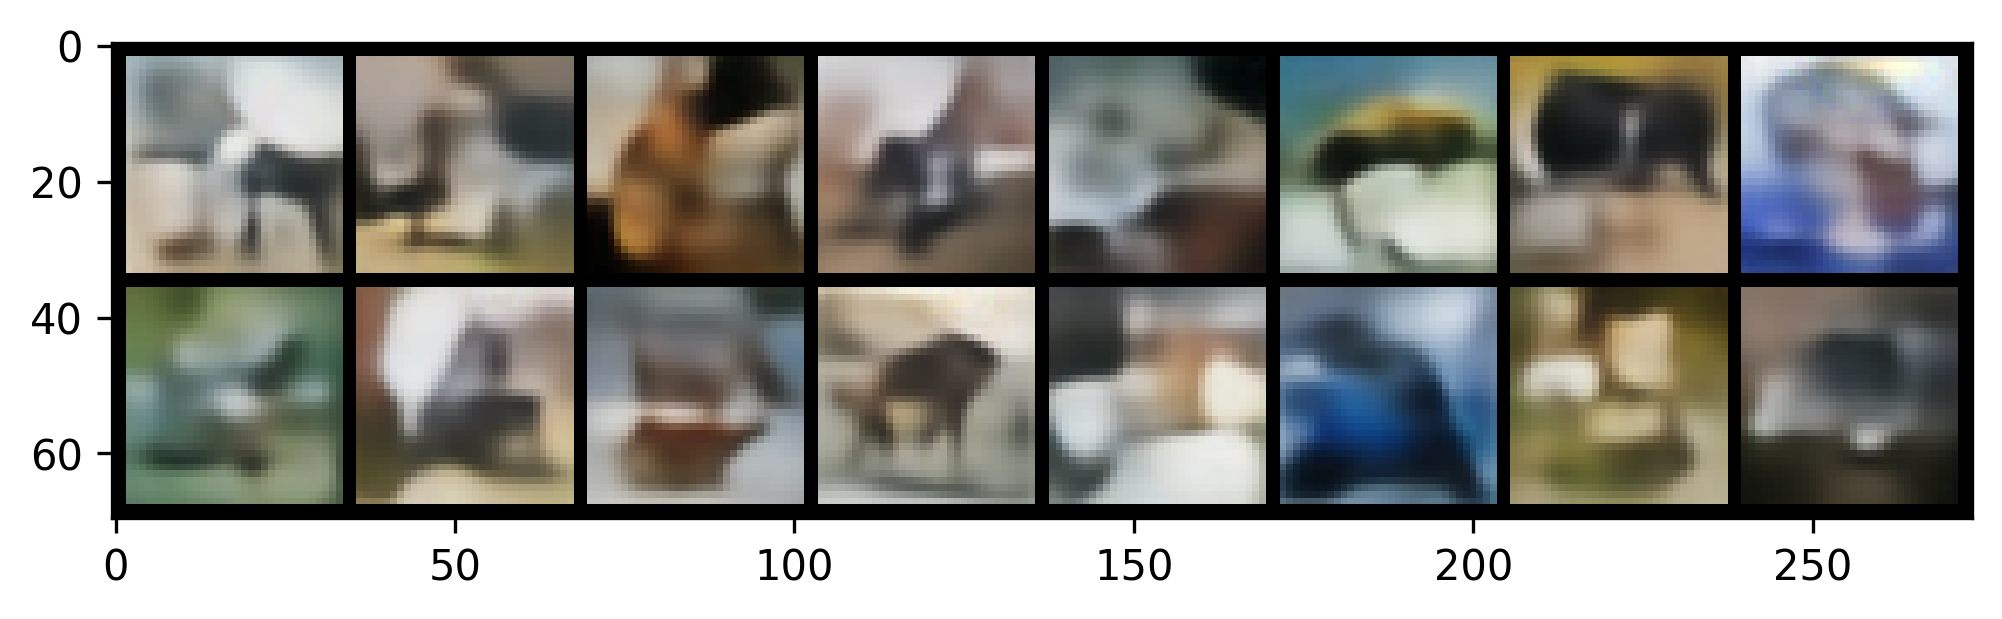

In [ ]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
figure(figsize=(8, 3), dpi=300)

# Z COMES FROM NORMAL(0, 1)
num_preds = 16
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
z = p.rsample((num_preds,))

# SAMPLE IMAGES
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

img = make_grid(pred).permute(1, 2, 0).numpy()

# PLOT IMAGES
imshow(img);